In [1]:
import psycopg2

In [3]:
con = psycopg2.connect(user = "postgres",
                       password = "",
                       host = "127.0.0.1",
                       port = "5432",
                       database = "adj_noun_pairs")

try:
    cursor = con.cursor();
except (Exception, psycopg2.Error) as error:
    print("Error in Connection",error)

In [5]:
try:
    cursor.execute("SELECT * FROM all_pairs_counts")
    pairs = cursor.fetchall() 
except (Exception, psycopg2.Error) as error:
    con.rollback()
    print("Error while inserting data into the table:", error)

In [7]:
print("Number of pairs:", len(pairs), "\nFirst pair and count:", pairs[0])

Number of pairs: 3070458 
First pair and count: ('eelmine', 'aasta', 53250)


### Number of pairs per threshold

Choosing thresholds and counting how many pairs are left if that threshold is applied. So for example if threshold is 10, then all pairs that occurred 10 times or less in the used texts are dropped and the number of pairs remaining is counted.

In [11]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

#### Threshold from 0 to 100

In [9]:
number_of_pairs = defaultdict(int)

for i in range(100):
    new_pairs = [pair for pair in pairs if pair[2] > i]
    number_of_pairs[i] = len(new_pairs)

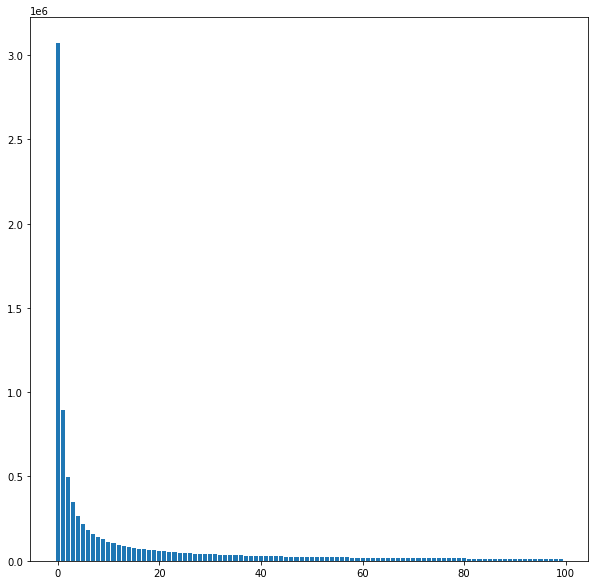

In [23]:
plt.figure(figsize=(10, 10))
plt.bar(*zip(*number_of_pairs.items()))
plt.show()

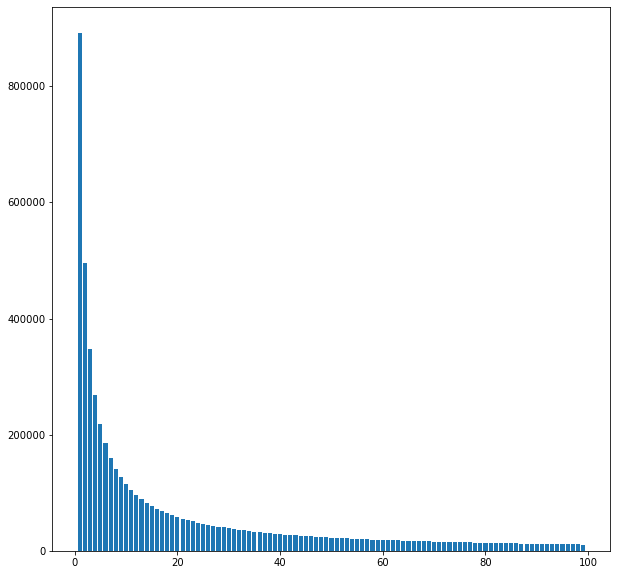

In [25]:
plt.figure(figsize=(10, 10))
plt.bar(*zip(*list(number_of_pairs.items())[1:]))
plt.show()

#### Threshold from 0 to 1000 with a step of 10

In [27]:
number_of_pairs_10 = defaultdict(int)

for i in range(0, 1000, 10):
    new_pairs = [pair for pair in pairs if pair[2] > i]
    number_of_pairs_10[i] = len(new_pairs)

In [60]:
number_of_pairs_10[990]

490

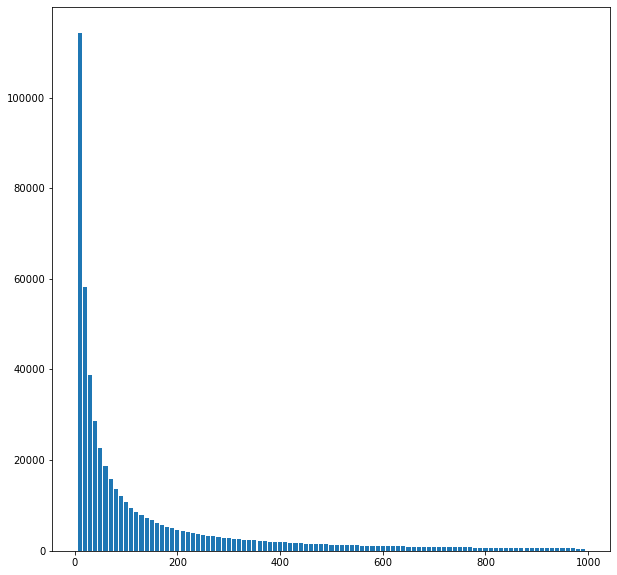

In [59]:
plt.figure(figsize=(10, 10))
plt.bar(*zip(*list(number_of_pairs_10.items())[1:]), width=8)
#plt.xticks(rotation=45)
#plt.setp(cbar.ax.get_xticklabels()[::2], visible=False)
#[label.set_visible(False) for i, label in enumerate(ax.xaxis.get_ticklabels()) if i % 10 != 0]
plt.show()

#### How many times the 100 most popular pairs appeared in the texts

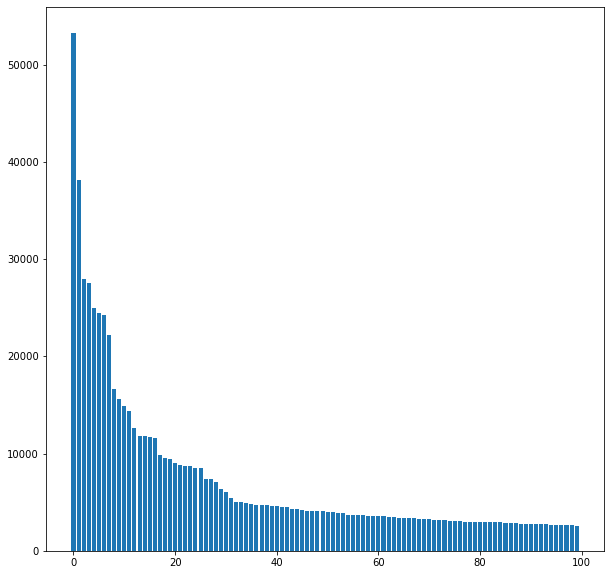

In [61]:
plt.figure(figsize=(10, 10))
plt.bar(range(100), [pair[2] for pair in pairs[:100]])
plt.show()

In [62]:
pairs[99]

('avalik', 'kord', 2599)

In [63]:
pairs[:10]

[('eelmine', 'aasta', 53250),
 ('järgmine', 'aasta', 38107),
 ('viimane', 'aeg', 27915),
 ('käesolev', 'määrus', 27514),
 ('kogu', 'aeg', 24997),
 ('viimane', 'aasta', 24410),
 ('kohalik', 'omavalitsus', 24261),
 ('suur', 'osa', 22165),
 ('suur', 'tänu', 16634),
 ('eelmine', 'nädal', 15648)]

#### Percentage of pairs over threshold

In [64]:
from copy import deepcopy

In [117]:
stat_per_threshold = {}

new_pairs = deepcopy(pairs)

for i in range(pairs[0][2] + 1):
    new_pairs = [pair for pair in new_pairs if pair[2] > i]
    stat_per_threshold[i] = (len(new_pairs), len(new_pairs) / len(pairs) * 100) # saving as number of pairs and percentage of pairs left per threshold, as I'm iterating until all pairs are dropped and may want to use all stats later

In [118]:
for key, value in stat_per_threshold.items():
    if value[1] < 1:
        print(key, value)
        break

38 (30262, 0.9855858637375923)


In [119]:
for key, value in stat_per_threshold.items():
    if value[1] < 0.1:
        print(key, value)
        break

277 (3064, 0.09978967307157434)


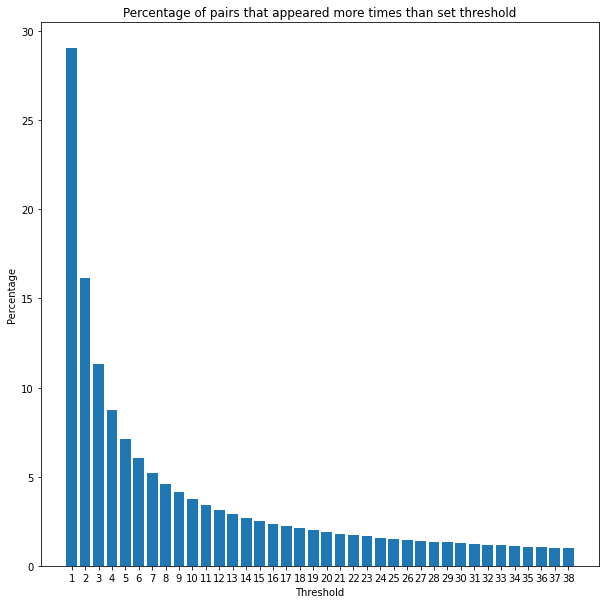

In [101]:
plt.figure(figsize=(10, 10))
plt.bar(list(range(1, 39)), [stat_per_threshold[i][1] for i in range(1, 39)])
plt.title("Percentage of pairs that appeared more times than set threshold")
plt.xlabel("Threshold")
plt.ylabel("Percentage")
plt.xticks(list(range(1, 39)))
plt.show()

### Power law

In [148]:
from plotnine import *
import pandas as pd

In [166]:
stats = [(key, value[0], value[1]) for key, value in stat_per_threshold.items()]

In [167]:
df = pd.DataFrame(stats, columns=['threshold','count' , 'percentage'])
df

,threshold,count,percentage
0,0,3070458,100.000000
1,1,891727,29.042149
2,2,496057,16.155798
3,3,347644,11.322220
4,4,268116,8.732117
...,...,...,...
53246,53246,1,0.000033
53247,53247,1,0.000033
53248,53248,1,0.000033
53249,53249,1,0.000033


In [174]:
df2 = df.drop_duplicates('count')

In [175]:
df2

,threshold,count,percentage
0,0,3070458,100.000000
1,1,891727,29.042149
2,2,496057,16.155798
3,3,347644,11.322220
4,4,268116,8.732117
...,...,...,...
24997,24997,4,0.000130
27514,27514,3,0.000098
27915,27915,2,0.000065
38107,38107,1,0.000033


C:\Users\Birgit\Anaconda3\envs\py36_estnltk\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10


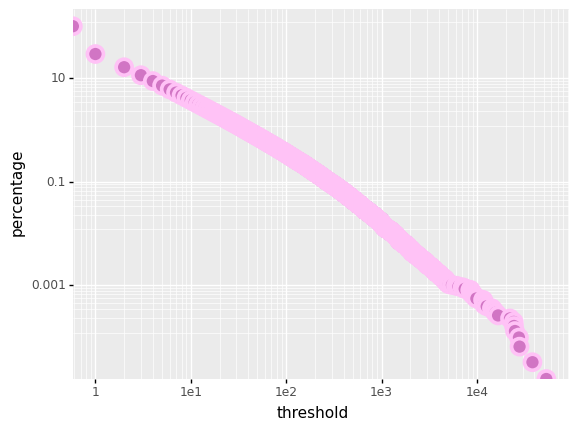

<ggplot: (180324392354)>

In [227]:
fig = (
    ggplot(data=df2) +
    aes(x = 'threshold', y = 'percentage') + 
    geom_point(fill = '#d175c4', 
               size = 5,
               stroke = 1.5,
               colour = '#ffc2f6',
               shape = 'o') +
    scale_x_log10() +
    scale_y_log10()
)
fig

In [183]:
from sklearn.linear_model import LinearRegression

In [224]:
lr = LinearRegression()
lr.fit(np.log10(df2[['threshold']]).drop(df2.tail(1).index).drop(df2.head(1).index), np.log10(df2[['percentage']].drop(df2.tail(1).index).drop(df2.head(1).index)))

C:\Users\Birgit\Anaconda3\envs\py36_estnltk\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10


LinearRegression()

In [229]:
print(lr.coef_, lr.intercept_)

[[-1.3648971]] [2.27536039]


C:\Users\Birgit\Anaconda3\envs\py36_estnltk\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10


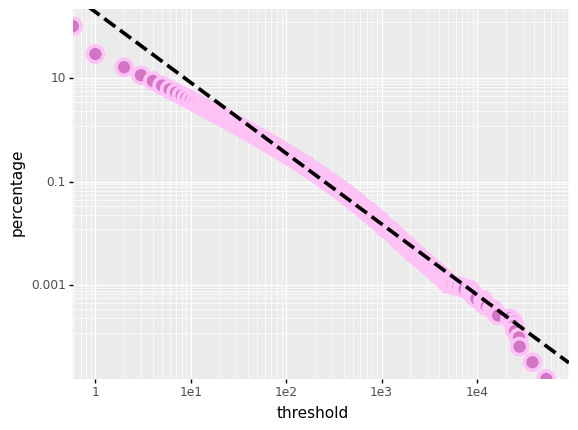

<ggplot: (180324356956)>

In [230]:
fig = fig + geom_abline(intercept = lr.intercept_, slope = lr.coef_[0], color="black", linetype="dashed", size=1.5)
fig